In this section, we investigate the contextual part of the network: The text on each page. First, we create a Word Cloud of two different community clusters to see if the key words capture core differences between them.

Secondly, we investigate sentiment analysis of the pages. As wikipedia pages are expected to be neutral, we do not expect any clusters to less / more happy. We did two different analysis. For both analysis, we removed redundant stop words.
 - The sentiment analysis based on the dictionary from the LabMT wordlist, and a custom calculate_sentiment_lc() function. This was performed on all the tokens on the raw page. 

 - A VADER (Valence Aware Dictionary and sEntiment Reasoner) on the entire page. With <-0.05 being considered negative, and >0.05 positive. A score between indicates neutrality. [https://github.com/cjhutto/vaderSentiment]

### Word Cloud

In [1]:
import pandas as pd
import numpy as np
from wordcloud import STOPWORDS

# 1. Load the Data
df = pd.read_csv("mushroom_communities_louvain_final.csv")

required_columns = ['community_louvain', 'views_all_time', 'mushroom', 'clean_text']
missing = [col for col in required_columns if col not in df.columns]

if missing:
    print(f"CRITICAL ERROR: Your CSV is missing these columns: {missing}")
else:
    print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
import re
from sklearn.feature_extraction import text

# 1. Text Cleaning Function (Kept same)
def clean_wiki_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\[\s*\d+\s*\]', '', text)
    text = re.sub(r'This .*? article is a stub\.', '', text)
    text = re.sub(r'You can help Wikipedia by expanding it\.', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. Base Stop Words
my_stop_words = [
    # Wikipedia / Academic
    'citation needed', 'citation', 'needed', 'commonly', 'known', 'common', 'name', 
    'described', 'reported', 'according', 'published', 'stub', 'article', 'wikipedia',
    'usually', 'generally', 'typically', 'often', 'although', 'though', 'may', 'can',
    'include', 'including', 'includes', 'contain', 'contains', 'containing', 'like', 'help',
    
    # Generic Biology
    'mushroom', 'mushrooms', 'species', 'fungus', 'fungi', 'genus', 'variety', 
    'specimen', 'fruit', 'fruiting', 'body', 'bodies', 'group', 'member', 'type',
    'found', 'grow', 'growing', 'grows', 'occur', 'occurs', 'occurring', 
    'distributed', 'distribution', 'range', 'native',
    
    # Generic Anatomy
    'cap', 'stem', 'stipe', 'gill', 'gills', 'spore', 'spores', 'flesh', 'surface', 
    'appearance', 'shape', 'color', 'colour', 'look', 'looks', 'similar', 'shape', 'shaped', 'veil', 'base', 
    
    # Units / Measurements
    'cm', 'mm', 'μm', 'um', 'g', 'mg', 'μg', 'centimeter', 'millimeter', 'inch', 
    'diameter', 'wide', 'width', 'long', 'length', 'thick', 'thickness', 'size', 
    'small', 'large', 'high', 'low', 'amount', 'level',
    
    # Numbers and time
    'one', 'two', 'three', 'four', 'first', 'second', 'year', 'month', 'day', 'time',
    'spring', 'summer', 'autumn', 'fall', 'winter',
    
    # Abbreviations / Single letters
    'l', 'c', 'p', 'sp', 'spp'
]

# Add A-Z single letters just to be safe (removes middle initials)
my_stop_words.extend(list('abcdefghijklmnopqrstuvwxyz'))

geo_stop_words = [
    'north', 'south', 'east', 'west', 
    'northern', 'southern', 'eastern', 'western',
    'america', 'american', 'europe', 'european', 'asia', 'asian', 
    'africa', 'african', 'australia', 'australian',
    'china', 'chinese', 'japan', 'japanese', 'mexico', 'mexican',
    'united', 'states', 'kingdom', 'canada', 'canadian', 'zealand',
    'world', 'temperate', 'tropical', 'hemisphere', 'region', 'regions',
    'distribution', 'distributed', 'native', 'introduced'
]

# 3. Combine Static Lists
# Start with standard English and add yours
final_stop_words = list(text.ENGLISH_STOP_WORDS) + my_stop_words + geo_stop_words

# 4. Dynamic Stop Words (The Fix)

# A. Taxonomy (Included 'mushroom' column here)
tax_cols = ['Division', 'Class', 'Order', 'Family', 'Genus', 'Species', 'mushroom']

for col in tax_cols:
    # Get unique values, drop NaNs
    unique_vals = df[col].dropna().unique()
    
    for val in unique_vals:
        s = str(val).lower()
        # This turns "auricula-judae" into "auricula judae"
        s_clean = re.sub(r'[^a-z0-9]', ' ', s)
        # Split by whitespace to get individual tokens
        words = s_clean.split()
        final_stop_words.extend(words)

# B. Morphology
morph_cols = ['sporePrintColor', 'howEdible', 'stipeCharacter', 'capShape', 
              'hymeniumType', 'ecologicalType', 'whichGills']

for col in morph_cols:
    # Explode lists first, then get unique
    unique_vals = df[col].explode().dropna().unique()
    
    for val in unique_vals:
        if isinstance(val, str):
            s = val.lower()
            # Apply same regex fix just in case (e.g. "blue-green")
            s_clean = re.sub(r'[^a-z0-9]', ' ', s)
            words = s_clean.split()
            final_stop_words.extend(words)

# 5. Final Deduplication
# This reduces the list size significantly and speeds up TF-IDF
final_stop_words = list(set(final_stop_words))

print(f"Stop word list compiled. Total unique words to ignore: {len(final_stop_words)}")

# 6. Apply Text Cleaning
df['clean_text'] = df['text'].apply(clean_wiki_text)

Stop word list compiled. Total unique words to ignore: 1929


Processing Cluster 4...
Processing Cluster 5...


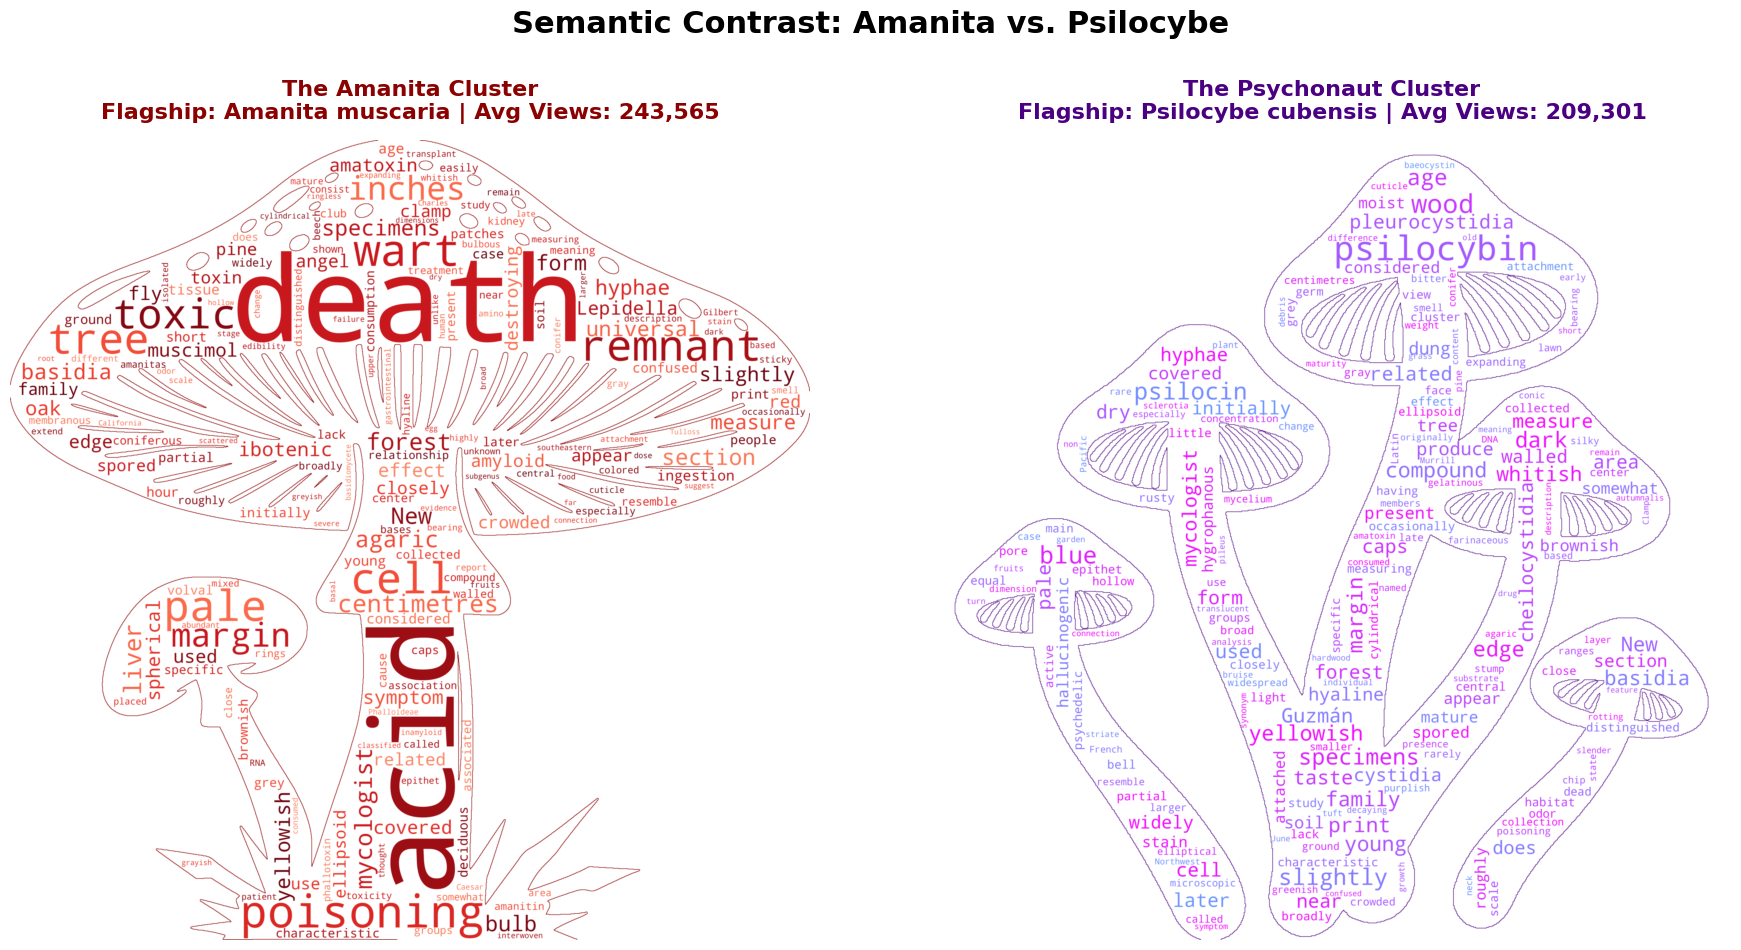

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from PIL import Image
import os

# 1. CONFIGURATION

# Define the specific settings for the two clusters
plot_settings = [
    {
        "cluster_id": 4,
        "title": "The Amanita Cluster",
        "mask_path": "mushroom_shapes/amanita2.png",
        "colormap": "Reds",           # Red/Orange tones for Amanita Muscaria look
        "contour_color": "#8B0000"    # Dark Red outline
    },
    {
        "cluster_id": 5,
        "title": "The Psychonaut Cluster",
        "mask_path": "mushroom_shapes/psilocybe.png",
        "colormap": "cool",           # Cyan/Magenta/Blue (Psychedelic/Bruising look)
        "contour_color": "#4B0082",    # Indigo/Deep Purple outline
    }
]

# 2. MASK LOADER

def load_mask(image_path, target_size=(2000, 2000)):
    """
    Loads an image, upscales it for smoothness, and converts to mask.
    target_size: (width, height) - Higher values = smoother contours.
    """
    try:
        icon = Image.open(image_path)
        
        # 1. UPSCALING: Resize the image to a large canvas 
        # using LANCZOS resampling to smooth out edges.
        icon = icon.resize(target_size, resample=Image.Resampling.LANCZOS)
        
        # Create white background
        bg = Image.new("RGB", icon.size, (255, 255, 255))
        
        # Handle transparency
        if icon.mode == 'RGBA':
            bg.paste(icon, mask=icon.split()[3])
        else:
            bg.paste(icon)
            
        mask_array = np.array(bg.convert("L"))
        
        # Binarize with a strict threshold to keep edges clean after resizing
        mask_array[mask_array > 200] = 255
        mask_array[mask_array <= 200] = 0
        
        return mask_array
        
    except FileNotFoundError:
        print(f"WARNING: Could not find {image_path}")
        return np.zeros(target_size, dtype=np.uint8)
    
# Use constrained_layout for better automatic spacing handling
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')
axes = axes.flatten()

for i, settings in enumerate(plot_settings):
    cluster_id = settings['cluster_id']
    ax = axes[i]
    
    print(f"Processing Cluster {cluster_id}...")
    
    # [Data loading steps remain the same...]
    nodes = df[df['community_louvain'] == cluster_id].index
    if len(nodes) == 0: continue
    subset = df.loc[nodes]
    flagship_idx = subset['views_all_time'].idxmax()
    flagship_name = subset.loc[flagship_idx, 'mushroom']
    avg_views = subset['views_all_time'].mean()
    text_corpus = " ".join(subset['clean_text'].astype(str))
    
    # Load Mask
    custom_mask = load_mask(settings['mask_path'])
    
    # This samples the colormap but restricts it to the darker 60% of the spectrum
    cmap = plt.get_cmap(settings['colormap'])
    def dark_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Pick a color from the darker end of the colormap (0.4 to 1.0)
        r, g, b, a = cmap(0.4 + np.random.rand() * 0.6) 
        return mcolors.to_hex((r, g, b))

    # GENERATE WORDCLOUD
    wc = WordCloud(
        background_color="white",
        stopwords=final_stop_words, 
        max_words=200,
        mask=custom_mask,
        color_func=dark_color_func,
        contour_width=3,
        contour_color=settings['contour_color'],
        width=custom_mask.shape[1],
        height=custom_mask.shape[0],
        min_font_size=6,
        scale=3,
        random_state=42,
        collocations=False
    )
    wc.generate(text_corpus)
    
    # Plot
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    
    # Dynamic Title
    title_str = (f"{settings['title']}\n"
                 f"Flagship: {flagship_name} | Avg Views: {int(avg_views):,}")
    
    ax.set_title(title_str, fontsize=16, fontweight='bold', 
                 color=settings['contour_color'], loc='center', pad=15)

# This creates the main title
plt.suptitle("Semantic Contrast: Amanita vs. Psilocybe", fontsize=22, fontweight='bold', y=0.98)

# This brings them closer. 
# wspace=0.0 means they touch. wspace=0.1 is a small gap.
plt.subplots_adjust(top=0.85, bottom=0.05, left=0.05, right=0.95, wspace=0.05)

plt.savefig("Cluster_Comparison_Improved.png", dpi=300, bbox_inches='tight')
plt.show()

### Sentiment Analysis

In [ ]:
# load in sentimet dict 
sentiment_df = pd.read_csv('../../data/Data_Set_S1.txt', sep='	', skiprows=3)
sentiment_df.head()
# Convert to dict for sentiment function
df_selected = sentiment_df[['word', 'happiness_average']]
sentiment_dict = pd.Series(df_selected.happiness_average.values,index=df_selected.word).to_dict()
# define function for sentiment. 
#list comprehension version
def calculate_sentiment_lc(tokenized_text, sentiment_dict = sentiment_dict):
    """
    Input: tokenized_text - list of words (pre-processed)
           sentiment_dict - dictionary with words as keys and sentiment scores as values
    Output: average sentiment score of the input text
    """
    words = tokenized_text

    # create a list of scores for words present in sentiment_dict
    scores = [sentiment_dict[word] for word in words if word in sentiment_dict]
    
    if not scores:
        return 0.0
    
    return sum(scores) / len(scores)

In [ ]:
import pandas as pd
import re
from collections import Counter

# --- CONFIGURATION ---
TOP_N_WORDS = 50 

# 1. OPTIMIZATION: Convert list to set for faster lookup (O(1) vs O(n))
# Ensure all stop words are lowercase to match tokenization
stop_words_set = set(word.lower() for word in final_stop_words)

# 2. SETUP DATAFRAME
if 'natural_stats' not in locals():
    natural_stats = pd.DataFrame(index=df['community_louvain'].unique())

natural_stats['Top_Keyword_Sentiment'] = 0.0
natural_stats['Top_Keywords_List'] = ""

print(f"Calculating sentiment for top {TOP_N_WORDS} meaningful words...")

# 3. CALCULATION LOOP
for cluster_id in natural_stats.index:
    
    # A. Get text corpus for the cluster
    cluster_mask = df['community_louvain'] == cluster_id
    # Join text, ensure it's string
    raw_text = " ".join(df.loc[cluster_mask, 'clean_text'].astype(str))
    
    # B. Tokenization & Cleaning
    # 1. Lowercase everything
    # 2. Use regex to grab only words (a-z), ignoring punctuation like '.' and ','
    # 3. Filter out tokens that are in the stop_words_set OR are too short (< 3 chars)
    tokens = re.findall(r'[a-z]+', raw_text.lower())
    
    clean_tokens = [
        t for t in tokens 
        if t not in stop_words_set and len(t) > 2
    ]
    
    # C. Count Frequencies
    word_counts = Counter(clean_tokens)
    
    # D. Extract Top N Words
    top_words_data = word_counts.most_common(TOP_N_WORDS)
    top_words_list = [word for word, count in top_words_data]
    
    # E. Calculate Sentiment
    avg_score = calculate_sentiment_lc(top_words_list, sentiment_dict)
    
    # F. Store Results
    natural_stats.at[cluster_id, 'Top_Keyword_Sentiment'] = avg_score
    natural_stats.at[cluster_id, 'Top_Keywords_List'] = ", ".join(top_words_list[:15])

# 4. VIEW RESULTS
# Sort by sentiment descending
result_view = natural_stats.sort_values('Top_Keyword_Sentiment', ascending=False)

# Display
pd.set_option('display.max_colwidth', 100)
print(result_view[['Top_Keyword_Sentiment', 'Top_Keywords_List']])

Calculating sentiment for top 50 meaningful words...
    Top_Keyword_Sentiment  \
1                6.100667   
10               5.714667   
11               5.706316   
14               5.611765   
6                5.609118   
0                5.581351   
9                5.560488   
13               5.542188   
3                5.520541   
2                5.514857   
15               5.481515   
5                5.455758   
7                5.435946   
16               5.431818   
4                5.370333   
8                5.368519   
12               5.337838   

                                                                                      Top_Keywords_List  
1   expanding, related, family, list, centimetres, forming, logs, wood, guzm, yellowish, new, cuba, ...  
10  puffball, layer, earthstar, truffle, rays, gleba, specimens, spherical, sac, young, truffles, ou...  
11  chanterelle, chanterelles, forests, jack, lantern, trees, related, specimens, used, considered, ...  


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# 1. Download the VADER lexicon (do this once)
nltk.download('vader_lexicon')

# 2. Initialize the analyzer
sia = SentimentIntensityAnalyzer()

# 3. Apply directly to your DataFrame
print("Calculating VADER sentiment...")

# This returns a score between -1 (Most Negative) and +1 (Most Positive)
df['vader_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# 4. Group by Louvain Community
natural_stats_vader = df.groupby('community_louvain')['vader_score'].agg(['mean', 'count'])
natural_stats_vader.columns = ['Avg_Sentiment', 'Post_Count']

# Sort and View
print(natural_stats_vader.sort_values('Avg_Sentiment', ascending=False))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/frederikreimert/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating VADER sentiment...
                   Avg_Sentiment  Post_Count
community_louvain                           
14                      0.400761          33
1                       0.399448         200
13                      0.384913          30
6                       0.384267          39
16                      0.355128          25
10                      0.353636          47
15                      0.190888          26
8                       0.154335          20
5                       0.153547         116
7                       0.144113          52
11                      0.106924          25
0                       0.057412          50
12                      0.032628          78
2                       0.021330          66
9                       0.019546         182
4                      -0.044235          71
3                      -0.152817          41


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We rebuild the plot data from the main 'df' to ensure all columns (Views, Family, Sentiment) align.
plot_data = df.groupby('community_louvain').agg({
    'vader_score': 'mean',
    'views_all_time': 'mean',
    'mushroom': 'count',
    # Calculate the most frequent Family in this cluster for naming
    'Family': lambda x: x.mode()[0] if not x.mode().empty else "Mixed" 
})

# Rename columns for clarity
plot_data.columns = ['Avg_Sentiment', 'Avg_Views', 'Size', 'Dominant_Family']

# Reset index so 'community_louvain' becomes a column we can plot
plot_data = plot_data.reset_index()


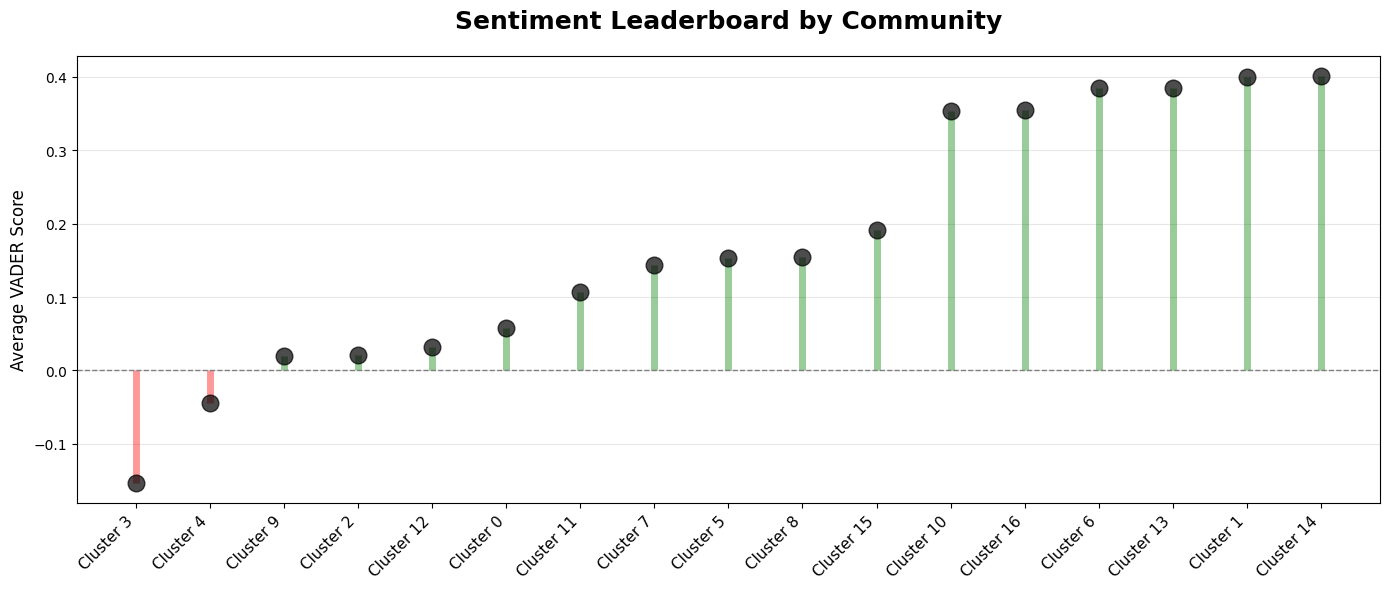

In [ ]:
import matplotlib.pyplot as plt

# LOLLIPOP CHART

# 1. Sort Data
sorted_data = plot_data.sort_values('Avg_Sentiment', ascending=True)

# 2. Create Colors
colors = ['red' if x < 0 else 'green' for x in sorted_data['Avg_Sentiment']]

# 3. Setup Figure (THE FIX)
# Change (10, 10) to (14, 6). 
# 14 is the width, 6 is the height. This creates a wide, flat "panoramic" look.
plt.figure(figsize=(14, 6)) 

# 4. Vertical Lines (Stems)
plt.vlines(
    x=range(len(sorted_data)), 
    ymin=0, 
    ymax=sorted_data['Avg_Sentiment'], 
    color=colors, 
    alpha=0.4, 
    linewidth=5
)

# 5. Dots (Heads)
plt.plot(
    range(len(sorted_data)), 
    sorted_data['Avg_Sentiment'], 
    "o", 
    markersize=12, 
    color='black', 
    alpha=0.7
)

# 6. Labels
plot_labels = []
for i, row in sorted_data.iterrows():
    plot_labels.append(f"Cluster {int(row['community_louvain'])}")

# Apply labels to X-axis
plt.xticks(
    ticks=range(len(sorted_data)), 
    labels=plot_labels, 
    fontsize=11, 
    rotation=45,     
    ha='right'       
)

# 7. Formatting
plt.title('Sentiment Leaderboard by Community', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Average VADER Score', fontsize=12)

# Reference Line at 0
plt.axhline(0, color='grey', linestyle='--', linewidth=1) 

# Grid
plt.grid(axis='y', alpha=0.3)

# Tight layout is crucial here to ensure the rotated labels don't get cut off at the bottom
plt.tight_layout()
plt.show()